# Artificial Neural Network

Goal: build a neural network to classify the handwritten digits from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The classifier is build from scratch.

## Import the libraries

In [11]:
# in case tensorflow and keras are not installed, uncomment these lines
#!pip install tensorflow

In [12]:
import datetime, os
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install -q -U keras-tuner
import keras_tuner as kt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, ReLU, ELU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
tf.__version__

'2.9.1'

In [14]:
tf.keras.__version__

'2.9.0'

## Prepare the dataset

11490434/11490434 [==============================] - 1s 0us/step


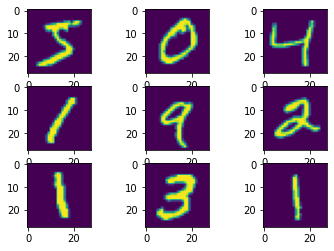

Train set has 60000 samples
Test set has 10000 samples


In [15]:
from keras.datasets import mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

print(f"Train set has {X_train_full.shape[0]} samples")
print(f"Test set has {X_test.shape[0]} samples")

What is the label distribution? *We observe that we have a balanced dataset at hand and thus we do not need to apply any further sampling.*

C:\Users\levi2\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

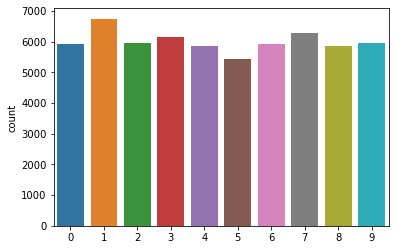

In [16]:
sns.countplot(y_train_full)

In [17]:
# normalisation
X_train_full = X_train_full/255.0
X_test = X_test/255.0

In [18]:
# Converts a class vector (integers) to one-hot encoding matrix.
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

y_train_full[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [21]:
# get validation dataset
np.random.seed(42) 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

## Build and train the model

The following approach was applied:

- **Finding a suitable base-line model**: First, we tried to get a feel for the task and thus randomly tried out a few models in order to find a suitable base-line model to be used as starting point for the hyperparameter tuning process. To do so, we started with a fixed node size and tried out a few variations and observed its performance on the train set.


- **Hyperparameter Tuning**: After getting a feel for the task and the tunable hyperparameters that may contribute to a successful model, we set the tunable hyperparameters and compute an exhaustive search for the best configuration based on the aquired intuition. To do so, we tried out the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner), which runs a bracket-style search for the best model configuration by repeatedly comparing two different models and keeping the ones with the better performance. Initially it runs on very low epochs and gradually increases the number of epochs in later stages of the bracket. Another added benefit is its natural integration with Tensorboard to better understand how the layers and hyperparameters interact with each other. 


- **Fine-tuning the resulting best model**: Once the search for the best hyperparameters is done, we further adjust the best model in a last attempt to increase its score and make the model more robust.


- **Evaluation on Test set**: Finally, after finding the best model configuration, we save the model and evaluate its performance on the test set.


### 1. Finding a suitable base-line model

In [24]:
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

def compile_and_train_model(model):
    model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.SGD(learning_rate=0.01), metrics=["accuracy"])
    history = model.fit(X_train, y_train, batch_size=30, epochs=30, validation_data=(X_valid, y_valid),  callbacks=[early_stopping])

The input and output layers are given, so therefore we first try to find a suitable number of hidden layers to use as a baseline model. Starting with 2 hidden layers:

In [25]:
model = Sequential()
# input layer
model.add(Flatten(input_shape=[28, 28]))
# hidden layers
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
# output layer
model.add(Dense(10, activation="softmax"))

model.summary()
compile_and_train_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1834/1834 [==============================] - 3s 1ms/step - loss: 0.5941 - accuracy: 0.8390 - val_loss: 0.3146 - val_accuracy: 0.9098
Epoch 2/30
1834/1834 [================

Sticking with the 2-hidden-layer-model, we now try adjusting the nodes such that they are not equal: **200,100** hidden layer nodes:

In [26]:
model = Sequential()
# input layer
model.add(Flatten(input_shape=[28, 28]))
# hidden layers
model.add(Dense(200, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
# output layer
model.add(Dense(10, activation="softmax"))

model.summary()
compile_and_train_model(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               157000    
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1834/1834 [==============================] - 3s 2ms/step - loss: 0.5699 - accuracy: 0.8484 - val_loss: 0.3141 - val_accuracy: 0.9130
Epoch 2/30
1834/1834 [==============

Does it improve the performance if we switch the hidden layer node sizes? **100, 200** hidden layer nodes:

In [27]:
model = Sequential()
# input layer
model.add(Flatten(input_shape=[28, 28]))
# hidden layers
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(200, activation="relu", kernel_initializer="he_normal"))
# output layer
model.add(Dense(10, activation="softmax"))

model.summary()
compile_and_train_model(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 100)               78500     
                                                                 
 dense_10 (Dense)            (None, 200)               20200     
                                                                 
 dense_11 (Dense)            (None, 10)                2010      
                                                                 
Total params: 100,710
Trainable params: 100,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1834/1834 [==============================] - 3s 1ms/step - loss: 0.5450 - accuracy: 0.8476 - val_loss: 0.3225 - val_accuracy: 0.9100
Epoch 2/30
1834/1834 [==============

What if we add a 3rd hidden layer and use a **uniform number of nodes**?

In [29]:
model = Sequential()
# input layer
model.add(Flatten(input_shape=[28, 28]))
# hidden layers
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
# output layer
model.add(Dense(10, activation="softmax"))

model.summary()
compile_and_train_model(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 100)               78500     
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 10)                1010      
                                                                 
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1834/1834 [============================

**We noticed that the model learned a lot faster, as it reaches lower loss and higher accuracy much faster (after a few epochs already) than the 2-hidden-layer models. However, the final scores are similar to the models before.** 

A first attempt to further improve is to change the hidden layer nodes to **200, 100, 100**:

In [30]:
model = Sequential()
# input layer
model.add(Flatten(input_shape=[28, 28]))
# hidden layers
model.add(Dense(200, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
# output layer
model.add(Dense(10, activation="softmax"))

model.summary()
compile_and_train_model(model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 200)               157000    
                                                                 
 dense_21 (Dense)            (None, 100)               20100     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 10)                1010      
                                                                 
Total params: 188,210
Trainable params: 188,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1834/1834 [==========================

We made further improvements, but let´s still try other variations of hidden layer nodes:


In [31]:
model = Sequential()
# input layer
model.add(Flatten(input_shape=[28, 28]))
# hidden layers
model.add(Dense(128, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(64, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(64, activation="relu", kernel_initializer="he_normal"))
# output layer
model.add(Dense(10, activation="softmax"))

model.summary()
compile_and_train_model(model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               100480    
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 10)                650       
                                                                 
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1834/1834 [==========================

Can we add a fourth hidden layer?

In [32]:
model = Sequential()
# input layer
model.add(Flatten(input_shape=[28, 28]))
# hidden layers
model.add(Dense(200, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
# output layer
model.add(Dense(10, activation="softmax"))

model.summary()
compile_and_train_model(model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_28 (Dense)            (None, 200)               157000    
                                                                 
 dense_29 (Dense)            (None, 100)               20100     
                                                                 
 dense_30 (Dense)            (None, 100)               10100     
                                                                 
 dense_31 (Dense)            (None, 100)               10100     
                                                                 
 dense_32 (Dense)            (None, 10)                1010      
                                                                 
Total params: 198,310
Trainable params: 198,310
Non-tr

Adding a fourth hidden layer does not seem to bring any noticeable improvements for this task. Also, at first sight there is no large benefit to a 3-hidden-layer model as opposed to 2-hidden-layer models. Therefore, we start with **2 hidden layers**.

### 2. Hyperparameter Tuning

To find the optimal hyperparameters for the task at hand, we try out [Keras Tuner](https://keras-team.github.io/keras-tuner/) which provides a very nice integration with Tensorboard to analyze our models.

#### 2-hidden-layer model


In [33]:
# This method is commonly used in combination with Keras Tuner,
# it continuously builds the models with a different hyperparamter configuration
# The following hyperparameters are defined:
#   - Hidden Layer 1 units: 256 --> 1024 (in steps of 128)
#   - Hidden Layer 2 units: 256 --> 1024 (in steps of 128)
#   - Weight Initializer: glorot_uniform, he_normal
#   - Optimizer: SGD, Adam
def model_builder(hp):
    model = Sequential()
    # input layer
    model.add(Flatten(input_shape=[28, 28]))
    # hidden layers
    hp_weight_init = hp.Choice('weight_init', values = ["glorot_uniform", "he_normal"]) 
    
    hp_hidd1_units = hp.Int('hidd1_units', min_value = 256, max_value = 1024, step = 128)
    model.add(Dense(hp_hidd1_units, activation="relu", kernel_initializer=hp_weight_init))

    hp_hidd2_units = hp.Int('hidd2_units', min_value = 256, max_value = 1024, step = 128)
    model.add(Dense(hp_hidd2_units, activation="relu", kernel_initializer=hp_weight_init))
    # output layer
    model.add(Dense(10, activation="softmax"))
    
    # other hyperparameters
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])

    model.compile(optimizer = optimizer,
                  loss = "categorical_crossentropy", 
                  metrics = ['accuracy'])
    
    return model

In [34]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir "./tensorboard/"

# tensorboard
logdir = os.path.join("./tensorboard/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [35]:
# This class takes care of deleting the Tuner output, 
# since this process can be very long and thus needs a lot of memory
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

# To avoid overfitting our models, we use early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# initialize Tuner
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 100,
                     factor = 3,
                     directory = './Hyperband')

# perform search for best hyperparameters
tuner.search(X_train, 
             y_train, 
             epochs = 100, 
             validation_data = (X_valid, y_valid), 
             callbacks = [ClearTrainingOutput(), early_stopping, tensorboard_callback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 254 Complete [00h 08m 44s]
val_accuracy: 0.982200026512146

Best val_accuracy So Far: 0.9854000210762024
Total elapsed time: 04h 31m 29s
INFO:tensorflow:Oracle triggered exit


In [36]:
print("Best hyperparameter configuration:")
print("Hidden Layer 1 units: ", best_hps.get("hidd1_units"))
print("Hidden Layer 2 units: ", best_hps.get("hidd2_units"))
print("Weight Initializer: ", best_hps.get("weight_init"))
print("Optimizer: ", best_hps.get("optimizer"))

Best hyperparameter configuration:
Hidden Layer 1 units:  896
Hidden Layer 2 units:  512
Weight Initializer:  he_normal
Optimizer:  adam


In [37]:
# retrieve best model and trial id (-> 0142)
model = tuner.get_best_models(num_models=1)[0]
print('Trial Id: ', tuner.oracle.get_best_trials()[0].trial_id)

Trial Id:  0142


### 3. Fine-tuning the best model

Train the best model properly. Additionally add Dropout layer to counteract overfitting.

In [38]:
model_adj = Sequential()
model_adj.add(Flatten(input_shape=[28, 28]))

model_adj.add(Dense(896, kernel_initializer="he_normal"))
model_adj.add(ReLU())
model_adj.add(Dropout(0.4))
model_adj.add(Dense(512, kernel_initializer="he_normal"))
model_adj.add(ReLU())
model_adj.add(Dropout(0.4))

model_adj.add(Dense(10, activation="softmax"))

In [39]:
model_adj.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [40]:
# adjusting early stopping patience
early_stopping_adj = EarlyStopping(monitor='val_accuracy', patience=3)
history = model_adj.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),  callbacks=[early_stopping_adj])

Epoch 1/100
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2634 - accuracy: 0.9191 - val_loss: 0.1145 - val_accuracy: 0.9650
Epoch 2/100
1719/1719 [==============================] - 14s 8ms/step - loss: 0.1391 - accuracy: 0.9580 - val_loss: 0.0872 - val_accuracy: 0.9726
Epoch 3/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.1117 - accuracy: 0.9660 - val_loss: 0.0835 - val_accuracy: 0.9752
Epoch 4/100
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0987 - accuracy: 0.9703 - val_loss: 0.0818 - val_accuracy: 0.9778
Epoch 5/100
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0933 - accuracy: 0.9721 - val_loss: 0.0699 - val_accuracy: 0.9808
Epoch 6/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0845 - accuracy: 0.9746 - val_loss: 0.0681 - val_accuracy: 0.9816
Epoch 7/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0762 - accuracy: 0.9776 - val_loss: 0.0754 -

### Training Process Conclusion

The dataset is susceptible to overfitting and not many epochs are needed to train a model for this task. A Dropout layer is added to counteract the overfitting. This means that the loss may be slightly higher and the validation accuracy slightly lower than before. However, the goal is to train a model that generalizes on unseen data (test dataset).

In [41]:
# save final model
model_adj.save('mnist_final.h5') 

## 4. Evaluation on Test Set



In [42]:
test_loss, test_acc = model_adj.evaluate(X_test, y_test, verbose=0)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

Test Loss:  0.07756257057189941
Test Accuracy:  0.9797999858856201


313/313 [==============================] - 1s 3ms/step


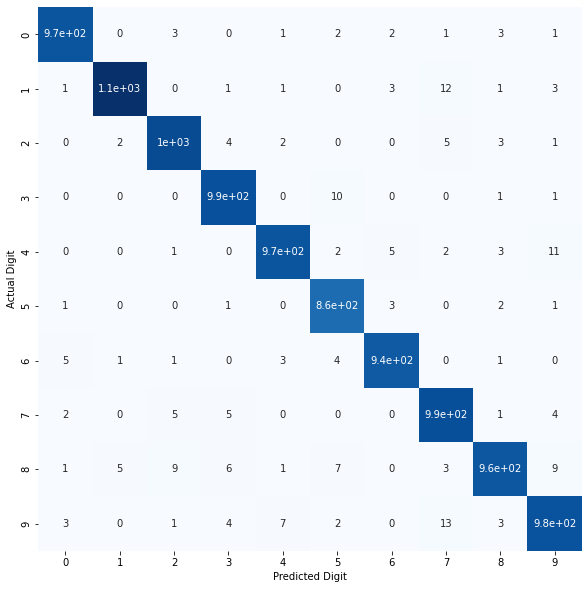

In [43]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10,10))

y_pred = model_adj.predict(X_test)

Y_pred = np.argmax(y_pred,1)
Y_test = np.argmax(y_test,1)

cm = confusion_matrix(Y_test, Y_pred)

sns.heatmap(cm.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Digit')
plt.ylabel('Actual Digit')
plt.show()